# Development imputing

In [1]:
import pandas as pd
from blocksnet.enums import LandUse

blocks = pd.read_pickle('blocks.pickle')
for lu in LandUse:
    blocks[lu.value] = blocks[lu.value].clip(lower=0, upper=1)

In [2]:
from blocksnet.relations import generate_adjacency_graph

graph = generate_adjacency_graph(blocks, 10)

2025-07-15 18:44:10.569 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:9 - Generating nodes
2025-07-15 18:44:10.573 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:14 - Generating edges
2025-07-15 18:44:13.397 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:37 - Adjacency graph successfully generated: 9368 nodes, 30291 edges


In [3]:
import torch
import torch.nn as nn
from torch_geometric.nn import GraphSAGE

class MultiScaleGNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.output_size = output_size
        self.graphsage = GraphSAGE(
            in_channels=input_size,
            hidden_channels=hidden_dim,
            num_layers=num_layers,
            out_channels=hidden_dim,
            dropout=dropout,
            act='relu',
            norm=nn.LayerNorm(hidden_dim),
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, output_size)
        )
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, *args, **kwargs):
        features = self.graphsage(x, edge_index)
        output = self.output_layer(features)
        return output

In [4]:
from sklearn.preprocessing import StandardScaler
from blocksnet.machine_learning.strategy.torch import TorchGraphImputationStrategy

strategy_params = {
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.5,
}

strategy = TorchGraphImputationStrategy(
    MultiScaleGNN, 
    strategy_params, 
    scalers={'x': StandardScaler(), 'y': StandardScaler()}
)

In [5]:
from blocksnet.preprocessing.imputing import DevelopmentImputer

imputer = DevelopmentImputer(strategy)

## Train

In [6]:
train_params = {
    'epochs': 1000,
    'optimizer_params': {
        "lr": 3e-4,
        "weight_decay": 1e-3
    },
}

train_losses, test_losses = imputer.train(blocks, graph, train_params=train_params)

Train loss: 0.44562 | Test loss: 0.35412: 100%|██████████| 1000/1000 [00:12<00:00, 80.93it/s]


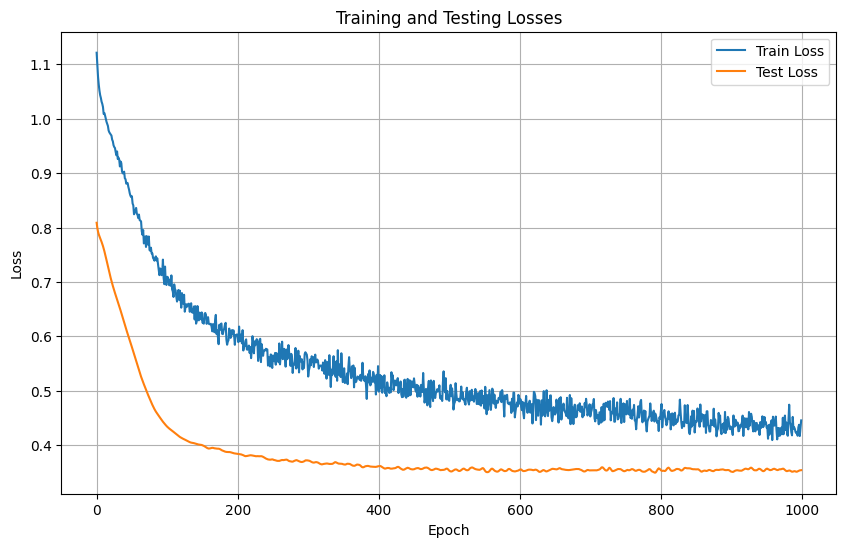

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

## Validate

In [8]:
imputer.validate(blocks, graph)

,mae,mse,r2
build_floor_area,30355.557928,4.290882e+09,0.570158
footprint_area,6939.220329,1.559075e+08,0.559558
living_area,14365.762549,1.347842e+09,0.551006


## Predict

In [10]:
imputer.run(blocks, graph, [1,2,3])

,build_floor_area,footprint_area,living_area
0,5955.883301,2846.785645,2482.416504
1,13463.683594,4789.432617,5233.006348
2,35736.691406,10071.825195,14045.833984
3,21338.931641,6704.631836,8075.080566
4,15290.441406,5210.451660,6027.676270
...,...,...,...
9363,34315.515625,9776.157227,12882.566406
9364,12259.783203,4491.377930,4555.119629
9365,14326.792969,4994.737793,5246.127441
9366,43649.867188,13069.380859,14095.022461
